In [2]:
!pip3 install pandas
!pip3 install tensorflow
!pip3 install numpy
!pip3 install codecarbon
!pip3 install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 436.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 1.2 MB/s eta 0:00:0000:0100:01


In [8]:
import pandas as pd


data = pd.read_csv('../full_dataset.csv')
data.drop('date', axis=1, inplace=True)
data.head()

,production,latitude,longitude,vmp,imp,voc,isc,p_per_m2,p_max,panel_area,...,wind_speed_10m_std,wind_speed_10m_min,wind_speed_10m_q1,wind_speed_10m_q2,wind_speed_10m_q3,wind_speed_10m_max,building_id,day,month,year
0,0.8,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.903114,1.3,1.900,3.00,3.450,4.1,1,1,1,2019
1,16.9,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.969186,0.9,2.975,3.50,3.825,4.8,1,2,1,2019
2,1.4,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.306945,0.4,1.100,1.20,1.400,1.9,1,3,1,2019
3,6.6,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.491844,0.4,0.800,1.20,1.725,2.1,1,4,1,2019
4,0.3,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.527737,1.6,2.275,2.85,3.100,3.4,1,5,1,2019


In [9]:
data_train = data[data['building_id'] != 8]
data_test = data[data['building_id'] == 8]

data_train.shape, data_test.shape

((9617, 164), (1254, 164))

In [10]:
target_column = 'production'

x_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column].values.reshape(-1, 1)

x_test = data_test.drop(target_column, axis=1)
y_test = data_test[target_column].values.reshape(-1, 1)

In [11]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [12]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(x_train)

x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [13]:
def get_windows(x, y, window_size):
    x_windows, y_windows = [], []

    for i in range(len(x) - window_size):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        x_window = np.hstack((x_window, y_window))

        x_windows.append(x_window)
        y_windows.append(y[i+window_size])

    return np.array(x_windows), np.array(y_windows)

In [14]:
x_train_windows, y_train_windows = get_windows(x_train_scaled, y_train, 10)
x_test_windows, y_test_windows = get_windows(x_test_scaled, y_test, 10)

In [15]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
tf.random.set_seed(42)

2024-05-13 09:06:08.788794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hugochampy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [30]:
model = Sequential([
    LSTM(1, activation='tanh', input_shape=(
        x_train_windows.shape[1:]), return_sequences=True),
    #lstm params :
    #     units
    #     activation
    Dropout(0.2),
    #params 
    #     rate
  

    
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    #params
    #     units
    #     activation

    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
# params 
#       learning_rate
model.compile(optimizer=optimizer, loss='mean_absolute_error')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 1)          │           664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,785 (85.10 KB)

 Trainable params: 21,785 (85.10 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import time
import logging
from codecarbon import EmissionsTracker


tracker = EmissionsTracker(
    project_name="3CABTP",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="lstm.csv",
    output_dir='../emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon WARNING @ 09:06:33] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 09:06:33] [setup] RAM Tracking...
[codecarbon INFO @ 09:06:33] [setup] GPU Tracking...
[codecarbon INFO @ 09:06:33] No GPU found.
[codecarbon INFO @ 09:06:33] [setup] CPU Tracking...
[codecarbon WARNING @ 09:06:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:06:36] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
[codecarbon INFO @ 09:06:36] >>> Tracker's metadata:
[codecarbon INFO @ 09:06:36]   Platform system: macOS-14.4.1-x86_64-i386-64bit
[codecarbon INFO @ 09:06:36]   Python version: 3.9.6
[codecarbon INFO @ 09:06:36]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 09:06:36]   Available RAM : 16.000 GB
[codecarbon INFO @ 09:06:36]   CPU count: 8
[codecarbon INFO @ 09:06:36]   CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
[codecarbon INFO @ 09:06:36]   GPU count: None
[codecarbon INFO @ 09:0

In [18]:
def start_training():
    start_time = time.time()
    history = model.fit(x=x_train_windows,
                        y=y_train_windows,
                        epochs=300,
                        batch_size=128,
                        validation_split=0.2,
                        shuffle=False)
    training_duration = time.time() - start_time
    #params 
    #      epochs
    #      batch_size

    return history, training_duration

In [19]:
tracker.start()
try:
    history, training_duration = start_training()
finally:
    tracker.stop()

Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 25.0478 - val_loss: 13.8126
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 17.5602 - val_loss: 11.4240
Epoch 3/300
 1/61 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 11.7612

[codecarbon INFO @ 09:06:49] Energy consumed for RAM : 0.000017 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:06:49] Energy consumed for all CPUs : 0.000039 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:06:49] 0.000056 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 15.9794 - val_loss: 12.5135
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 15.4289 - val_loss: 11.6980
Epoch 5/300
23/61 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 10.0312

[codecarbon INFO @ 09:06:59] Energy consumed for RAM : 0.000033 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:06:59] Energy consumed for all CPUs : 0.000078 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:06:59] 0.000111 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 14.9194 - val_loss: 11.4988
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 14.6217 - val_loss: 10.9250
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 13.7064 - val_loss: 11.0027
Epoch 8/300
35/61 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.4005

[codecarbon INFO @ 09:07:09] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W


36/61 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.3870

[codecarbon INFO @ 09:07:09] Energy consumed for all CPUs : 0.000117 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:09] 0.000167 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 13.3124 - val_loss: 10.7610
Epoch 9/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 13.0073 - val_loss: 11.0720
Epoch 10/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 12.9385 - val_loss: 11.3108
Epoch 11/300
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 11.9136

[codecarbon INFO @ 09:07:19] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:07:19] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:19] 0.000222 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 12.7194 - val_loss: 10.5514
Epoch 12/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 12.4385 - val_loss: 10.7067
Epoch 13/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 12.3529 - val_loss: 11.3056
Epoch 14/300
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 11.2672

[codecarbon INFO @ 09:07:28] Energy consumed for RAM : 0.000083 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:07:28] Energy consumed for all CPUs : 0.000194 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:28] 0.000277 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 12.3644 - val_loss: 11.0523
Epoch 15/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 12.2691 - val_loss: 10.6444
Epoch 16/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 12.1533 - val_loss: 10.7458
Epoch 17/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 12.1570 - val_loss: 10.7339
Epoch 18/300
23/61 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.6906

[codecarbon INFO @ 09:07:38] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:07:38] Energy consumed for all CPUs : 0.000232 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:38] 0.000332 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 11.9489 - val_loss: 10.7697
Epoch 19/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 11.9460 - val_loss: 10.7244
Epoch 20/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 12.0767 - val_loss: 10.7752
Epoch 21/300
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 10.5226

[codecarbon INFO @ 09:07:48] Energy consumed for RAM : 0.000116 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:07:48] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:48] 0.000388 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 11.8958 - val_loss: 10.6424
Epoch 22/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 11.7129 - val_loss: 10.4526
Epoch 23/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 11.7041 - val_loss: 10.5300
Epoch 24/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 11.8505 - val_loss: 10.4309
Epoch 25/300
 7/61 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.3754

[codecarbon INFO @ 09:07:58] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:07:58] Energy consumed for all CPUs : 0.000310 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:07:58] 0.000443 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 11.6335 - val_loss: 10.3231
Epoch 26/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 11.4948 - val_loss: 10.4431
Epoch 27/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 11.3517 - val_loss: 10.4293
Epoch 28/300
25/61 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.4980

[codecarbon INFO @ 09:08:08] Energy consumed for RAM : 0.000150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:08:08] Energy consumed for all CPUs : 0.000349 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:08] 0.000499 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 11.3727 - val_loss: 10.4849
Epoch 29/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 11.2626 - val_loss: 10.4305
Epoch 30/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 11.1831 - val_loss: 10.2569
Epoch 31/300


[codecarbon INFO @ 09:08:18] Energy consumed for RAM : 0.000166 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:08:18] Energy consumed for all CPUs : 0.000388 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:18] 0.000554 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 11.3964 - val_loss: 10.5277
Epoch 32/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 11.1501 - val_loss: 10.1252
Epoch 33/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 11.2359 - val_loss: 10.0838
Epoch 34/300
17/61 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.9544

[codecarbon INFO @ 09:08:28] Energy consumed for RAM : 0.000183 kWh. RAM Power : 6.0 W


19/61 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.0156

[codecarbon INFO @ 09:08:28] Energy consumed for all CPUs : 0.000427 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:28] 0.000610 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 10.8096 - val_loss: 9.9447
Epoch 35/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10.6900 - val_loss: 9.8053
Epoch 36/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10.7632 - val_loss: 10.1086
Epoch 37/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 10.9315 - val_loss: 9.9969
Epoch 38/300
 9/61 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.5626

[codecarbon INFO @ 09:08:38] Energy consumed for RAM : 0.000200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:08:38] Energy consumed for all CPUs : 0.000466 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:38] 0.000665 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 10.7333 - val_loss: 9.6820
Epoch 39/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 10.4092 - val_loss: 9.9595
Epoch 40/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 10.5205 - val_loss: 10.1405
Epoch 41/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 10.4525 - val_loss: 9.6395
Epoch 42/300
 1/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.4709

[codecarbon INFO @ 09:08:48] Energy consumed for RAM : 0.000216 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:08:48] Energy consumed for all CPUs : 0.000505 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:48] 0.000721 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10.3661 - val_loss: 10.0003
Epoch 43/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 10.4185 - val_loss: 9.9196
Epoch 44/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 10.2853 - val_loss: 9.5768
Epoch 45/300
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.6641

[codecarbon INFO @ 09:08:58] Energy consumed for RAM : 0.000233 kWh. RAM Power : 6.0 W


60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.8629

[codecarbon INFO @ 09:08:58] Energy consumed for all CPUs : 0.000544 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:08:58] 0.000776 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10.0471 - val_loss: 9.6025
Epoch 46/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10.0757 - val_loss: 9.5570
Epoch 47/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 10.0885 - val_loss: 9.7370
Epoch 48/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 10.4244 - val_loss: 9.5853
Epoch 49/300
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.1321

[codecarbon INFO @ 09:09:08] Energy consumed for RAM : 0.000250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:08] Energy consumed for all CPUs : 0.000582 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:09:08] 0.000832 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.8712 - val_loss: 9.4571
Epoch 50/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.7596 - val_loss: 9.3273
Epoch 51/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.6478 - val_loss: 9.3254
Epoch 52/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 9.6010 - val_loss: 9.3917
Epoch 53/300
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.8396

[codecarbon INFO @ 09:09:18] Energy consumed for RAM : 0.000266 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:18] Energy consumed for all CPUs : 0.000621 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:09:18] 0.000887 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.7308 - val_loss: 9.5989
Epoch 54/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.5337 - val_loss: 9.1877
Epoch 55/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.3326 - val_loss: 9.1572
Epoch 56/300
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.9852

[codecarbon INFO @ 09:09:28] Energy consumed for RAM : 0.000283 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:28] Energy consumed for all CPUs : 0.000660 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:09:28] 0.000943 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 9.2428 - val_loss: 9.1686
Epoch 57/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 9.1195 - val_loss: 8.8997
Epoch 58/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.1076 - val_loss: 9.2136
Epoch 59/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.0670 - val_loss: 8.8934
Epoch 60/300


[codecarbon INFO @ 09:09:38] Energy consumed for RAM : 0.000300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:38] Energy consumed for all CPUs : 0.000699 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:09:38] 0.000999 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.1422 - val_loss: 9.0130
Epoch 61/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 9.1839 - val_loss: 8.9232
Epoch 62/300
28/61 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.7469

[codecarbon INFO @ 09:09:48] Energy consumed for RAM : 0.000316 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:48] Energy consumed for all CPUs : 0.000738 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:09:48] 0.001054 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.9910 - val_loss: 8.9031
Epoch 63/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.0027 - val_loss: 8.7487
Epoch 64/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.9056 - val_loss: 9.0381
Epoch 65/300
40/61 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.5723

[codecarbon INFO @ 09:09:58] Energy consumed for RAM : 0.000333 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:09:58] Energy consumed for all CPUs : 0.000777 kWh. Total CPU Power : 14.0 W


41/61 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 6.6267

[codecarbon INFO @ 09:09:58] 0.001110 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.9607 - val_loss: 8.9866
Epoch 66/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 8.8262 - val_loss: 8.8990
Epoch 67/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 8.8220 - val_loss: 8.9133
Epoch 68/300
48/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.3776

[codecarbon INFO @ 09:10:08] Energy consumed for RAM : 0.000349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:08] Energy consumed for all CPUs : 0.000816 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:08] 0.001165 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 8.8772 - val_loss: 8.8571
Epoch 69/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 8.8863 - val_loss: 9.1042
Epoch 70/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.5527 - val_loss: 9.2424
Epoch 71/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.5781 - val_loss: 8.6658
Epoch 72/300
19/61 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.9907

[codecarbon INFO @ 09:10:18] Energy consumed for RAM : 0.000366 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:18] Energy consumed for all CPUs : 0.000855 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:18] 0.001221 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.3612 - val_loss: 8.9164
Epoch 73/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.3183 - val_loss: 8.4942
Epoch 74/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.2070 - val_loss: 8.5242
Epoch 75/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.2677 - val_loss: 8.4765
Epoch 76/300
 7/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 5.8483

[codecarbon INFO @ 09:10:28] Energy consumed for RAM : 0.000383 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:28] Energy consumed for all CPUs : 0.000893 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:28] 0.001276 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.1076 - val_loss: 8.5510
Epoch 77/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.9747 - val_loss: 8.5979
Epoch 78/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.9600 - val_loss: 8.3468
Epoch 79/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.9050 - val_loss: 8.5154
Epoch 80/300
 1/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 5.0324

[codecarbon INFO @ 09:10:38] Energy consumed for RAM : 0.000399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:38] Energy consumed for all CPUs : 0.000932 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:38] 0.001332 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.8888 - val_loss: 8.7950
Epoch 81/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.8504 - val_loss: 8.6305
Epoch 82/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.8302 - val_loss: 8.3698
Epoch 83/300
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.7751

[codecarbon INFO @ 09:10:48] Energy consumed for RAM : 0.000416 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:48] Energy consumed for all CPUs : 0.000971 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:48] 0.001387 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.9278 - val_loss: 8.4850
Epoch 84/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7.5708 - val_loss: 8.4332
Epoch 85/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.6385 - val_loss: 8.2773
Epoch 86/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.7714 - val_loss: 8.3132
Epoch 87/300
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.8584

[codecarbon INFO @ 09:10:58] Energy consumed for RAM : 0.000433 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:10:58] Energy consumed for all CPUs : 0.001010 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:10:58] 0.001443 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.0200 - val_loss: 8.4206
Epoch 88/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.0109 - val_loss: 8.4100
Epoch 89/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.8200 - val_loss: 8.1929
Epoch 90/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.5719 - val_loss: 8.2564
Epoch 91/300
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.1369

[codecarbon INFO @ 09:11:08] Energy consumed for RAM : 0.000449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:08] Energy consumed for all CPUs : 0.001049 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:08] 0.001498 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.4141 - val_loss: 8.2381
Epoch 92/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.3550 - val_loss: 8.1007
Epoch 93/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.2260 - val_loss: 8.3218
Epoch 94/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.1483 - val_loss: 8.2443
Epoch 95/300
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.8484

[codecarbon INFO @ 09:11:18] Energy consumed for RAM : 0.000466 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:18] Energy consumed for all CPUs : 0.001088 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:18] 0.001554 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.2795 - val_loss: 8.4351
Epoch 96/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7.0754 - val_loss: 8.0499
Epoch 97/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.3363 - val_loss: 8.7031
Epoch 98/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.3999 - val_loss: 8.1940
Epoch 99/300
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.1992

[codecarbon INFO @ 09:11:28] Energy consumed for RAM : 0.000483 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:28] Energy consumed for all CPUs : 0.001127 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:28] 0.001609 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.9974 - val_loss: 8.3811
Epoch 100/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.9874 - val_loss: 7.9659
Epoch 101/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.0758 - val_loss: 8.2542
Epoch 102/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.1923 - val_loss: 8.2201
Epoch 103/300
43/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.2683

[codecarbon INFO @ 09:11:38] Energy consumed for RAM : 0.000499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:38] Energy consumed for all CPUs : 0.001166 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:38] 0.001665 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.1006 - val_loss: 8.1642
Epoch 104/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.0191 - val_loss: 8.1332
Epoch 105/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.7814 - val_loss: 8.0234
Epoch 106/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.8674 - val_loss: 7.8935
Epoch 107/300
12/61 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4.4948

[codecarbon INFO @ 09:11:48] Energy consumed for RAM : 0.000516 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:48] Energy consumed for all CPUs : 0.001205 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:48] 0.001721 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.6624 - val_loss: 7.8999
Epoch 108/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.6365 - val_loss: 7.9832
Epoch 109/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.5938 - val_loss: 8.0116
Epoch 110/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.7363 - val_loss: 8.3260
Epoch 111/300


[codecarbon INFO @ 09:11:58] Energy consumed for RAM : 0.000533 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:11:58] Energy consumed for all CPUs : 0.001243 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:11:58] 0.001776 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.7520 - val_loss: 7.8203
Epoch 112/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.3771 - val_loss: 7.6491
Epoch 113/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.3674 - val_loss: 7.9553
Epoch 114/300
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.2737

[codecarbon INFO @ 09:12:08] Energy consumed for RAM : 0.000549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:08] Energy consumed for all CPUs : 0.001282 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:08] 0.001832 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.4593 - val_loss: 7.9216
Epoch 115/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.4012 - val_loss: 8.0751
Epoch 116/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.4041 - val_loss: 7.7590
Epoch 117/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.2162 - val_loss: 8.3373
Epoch 118/300
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.0251

[codecarbon INFO @ 09:12:18] Energy consumed for RAM : 0.000566 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:18] Energy consumed for all CPUs : 0.001321 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:18] 0.001887 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.5033 - val_loss: 8.0044
Epoch 119/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 6.3116 - val_loss: 7.8099
Epoch 120/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.1640 - val_loss: 8.1749
Epoch 121/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.2912 - val_loss: 7.7087
Epoch 122/300
11/61 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.1282

[codecarbon INFO @ 09:12:28] Energy consumed for RAM : 0.000583 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:28] Energy consumed for all CPUs : 0.001360 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:28] 0.001943 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.2760 - val_loss: 7.7616
Epoch 123/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 6.2751 - val_loss: 7.7372
Epoch 124/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.2580 - val_loss: 7.7294
Epoch 125/300
35/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.3511

[codecarbon INFO @ 09:12:38] Energy consumed for RAM : 0.000599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:38] Energy consumed for all CPUs : 0.001399 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:38] 0.001998 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.2672 - val_loss: 7.6581
Epoch 126/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.1764 - val_loss: 7.5496
Epoch 127/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.9856 - val_loss: 7.6581
Epoch 128/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.2761 - val_loss: 8.1675
Epoch 129/300
25/61 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.7893

[codecarbon INFO @ 09:12:48] Energy consumed for RAM : 0.000616 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:48] Energy consumed for all CPUs : 0.001438 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:48] 0.002054 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.4425 - val_loss: 7.9929
Epoch 130/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.9433 - val_loss: 7.6759
Epoch 131/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.9281 - val_loss: 7.6179
Epoch 132/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.8289 - val_loss: 7.5227
Epoch 133/300
10/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.8598

[codecarbon INFO @ 09:12:58] Energy consumed for RAM : 0.000633 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:12:58] Energy consumed for all CPUs : 0.001477 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:12:58] 0.002109 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.7424 - val_loss: 7.6503
Epoch 134/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.8458 - val_loss: 7.5197
Epoch 135/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.8075 - val_loss: 7.6110
Epoch 136/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.7861 - val_loss: 7.7042
Epoch 137/300


[codecarbon INFO @ 09:13:08] Energy consumed for RAM : 0.000649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:08] Energy consumed for all CPUs : 0.001516 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:08] 0.002165 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 5.7972 - val_loss: 7.5526
Epoch 138/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.7480 - val_loss: 7.5169
Epoch 139/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.6998 - val_loss: 7.5926
Epoch 140/300
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.7548

[codecarbon INFO @ 09:13:18] Energy consumed for RAM : 0.000666 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:18] Energy consumed for all CPUs : 0.001555 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:18] 0.002221 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.7080 - val_loss: 8.6304
Epoch 141/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.1055 - val_loss: 7.9279
Epoch 142/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.8577 - val_loss: 7.4966
Epoch 143/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.5773 - val_loss: 7.5657
Epoch 144/300
23/61 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.8536

[codecarbon INFO @ 09:13:28] Energy consumed for RAM : 0.000683 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:28] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:28] 0.002276 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.6159 - val_loss: 7.5587
Epoch 145/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.8123 - val_loss: 7.4125
Epoch 146/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.4855 - val_loss: 7.6048
Epoch 147/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.4046

[codecarbon INFO @ 09:13:38] Energy consumed for RAM : 0.000699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:38] Energy consumed for all CPUs : 0.001632 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:38] 0.002332 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.4578 - val_loss: 7.3277
Epoch 148/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.3854 - val_loss: 7.4914
Epoch 149/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.4815 - val_loss: 7.5686
Epoch 150/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.4775 - val_loss: 7.9664
Epoch 151/300
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9134

[codecarbon INFO @ 09:13:48] Energy consumed for RAM : 0.000716 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:48] Energy consumed for all CPUs : 0.001671 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:48] 0.002387 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.6580 - val_loss: 7.4350
Epoch 152/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.3231 - val_loss: 7.7209
Epoch 153/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.4407 - val_loss: 7.4287
Epoch 154/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.3648 - val_loss: 7.2767
Epoch 155/300
35/61 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.4754

[codecarbon INFO @ 09:13:58] Energy consumed for RAM : 0.000733 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:13:58] Energy consumed for all CPUs : 0.001710 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:13:58] 0.002443 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.1614 - val_loss: 7.3591
Epoch 156/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.2779 - val_loss: 7.3386
Epoch 157/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.3405 - val_loss: 7.6835
Epoch 158/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.3413 - val_loss: 7.5470
Epoch 159/300
23/61 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.5662

[codecarbon INFO @ 09:14:08] Energy consumed for RAM : 0.000749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:08] Energy consumed for all CPUs : 0.001749 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:08] 0.002498 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.2556 - val_loss: 7.4753
Epoch 160/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.3049 - val_loss: 7.6362
Epoch 161/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.2277 - val_loss: 7.4338
Epoch 162/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.0990 - val_loss: 7.5578
Epoch 163/300
 7/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.4118

[codecarbon INFO @ 09:14:18] Energy consumed for RAM : 0.000766 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:18] Energy consumed for all CPUs : 0.001788 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:18] 0.002554 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.2874 - val_loss: 7.2867
Epoch 164/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.1874 - val_loss: 7.8500
Epoch 165/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.1641 - val_loss: 7.2662
Epoch 166/300
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.8716

[codecarbon INFO @ 09:14:28] Energy consumed for RAM : 0.000783 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:28] Energy consumed for all CPUs : 0.001827 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:28] 0.002609 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.0300 - val_loss: 7.4360
Epoch 167/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.2499 - val_loss: 7.5702
Epoch 168/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 5.4460 - val_loss: 7.6012
Epoch 169/300
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.2148

[codecarbon INFO @ 09:14:38] Energy consumed for RAM : 0.000799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:38] Energy consumed for all CPUs : 0.001866 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:38] 0.002665 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.0987 - val_loss: 7.4243
Epoch 170/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.9764 - val_loss: 7.4722
Epoch 171/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.1330 - val_loss: 7.2318
Epoch 172/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.0021 - val_loss: 7.1572
Epoch 173/300
36/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.2778

[codecarbon INFO @ 09:14:48] Energy consumed for RAM : 0.000816 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:48] Energy consumed for all CPUs : 0.001904 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:48] 0.002720 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7692 - val_loss: 7.0676
Epoch 174/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.7990 - val_loss: 7.1996
Epoch 175/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.8436 - val_loss: 7.2171
Epoch 176/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7212 - val_loss: 7.3761
Epoch 177/300
22/61 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 3.2410

[codecarbon INFO @ 09:14:58] Energy consumed for RAM : 0.000833 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:14:58] Energy consumed for all CPUs : 0.001943 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:14:58] 0.002776 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.7691 - val_loss: 7.2644
Epoch 178/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.7893 - val_loss: 7.2322
Epoch 179/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.8461 - val_loss: 7.1932
Epoch 180/300
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.9246

[codecarbon INFO @ 09:15:08] Energy consumed for RAM : 0.000849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:08] Energy consumed for all CPUs : 0.001982 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:08] 0.002832 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.7728 - val_loss: 7.6239
Epoch 181/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 5.2051 - val_loss: 7.4544
Epoch 182/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.8587 - val_loss: 7.4144
Epoch 183/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 4.8783 - val_loss: 7.6009
Epoch 184/300
10/61 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.2298

[codecarbon INFO @ 09:15:18] Energy consumed for RAM : 0.000866 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:18] Energy consumed for all CPUs : 0.002021 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:18] 0.002887 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 4.9849 - val_loss: 7.4922
Epoch 185/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.9041 - val_loss: 7.3202
Epoch 186/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.9027 - val_loss: 7.4205
Epoch 187/300
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.4968

[codecarbon INFO @ 09:15:28] Energy consumed for RAM : 0.000883 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:28] Energy consumed for all CPUs : 0.002060 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:28] 0.002943 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.8999 - val_loss: 7.2635
Epoch 188/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.7968 - val_loss: 7.4782
Epoch 189/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7902 - val_loss: 7.2192
Epoch 190/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7999 - val_loss: 7.2978
Epoch 191/300
39/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.2675

[codecarbon INFO @ 09:15:38] Energy consumed for RAM : 0.000899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:38] Energy consumed for all CPUs : 0.002099 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:38] 0.002998 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.8010 - val_loss: 7.1951
Epoch 192/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.9858 - val_loss: 7.5238
Epoch 193/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.8793 - val_loss: 7.3796
Epoch 194/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.6515 - val_loss: 7.3711
Epoch 195/300
25/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.3112

[codecarbon INFO @ 09:15:48] Energy consumed for RAM : 0.000916 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:48] Energy consumed for all CPUs : 0.002138 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:48] 0.003054 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.6967 - val_loss: 7.1174
Epoch 196/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5452 - val_loss: 7.3376
Epoch 197/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.7249 - val_loss: 7.2410
Epoch 198/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5357 - val_loss: 7.1687
Epoch 199/300
 9/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.8103

[codecarbon INFO @ 09:15:58] Energy consumed for RAM : 0.000933 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:15:58] Energy consumed for all CPUs : 0.002177 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:15:58] 0.003109 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.5417 - val_loss: 7.3188
Epoch 200/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.6281 - val_loss: 7.3402
Epoch 201/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.6674 - val_loss: 7.1139
Epoch 202/300
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.4168

[codecarbon INFO @ 09:16:08] Energy consumed for RAM : 0.000949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:08] Energy consumed for all CPUs : 0.002216 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:08] 0.003165 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5692 - val_loss: 6.9975
Epoch 203/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.4046 - val_loss: 7.1654
Epoch 204/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3625 - val_loss: 7.3639
Epoch 205/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.4973 - val_loss: 7.1691
Epoch 206/300
41/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.0449

[codecarbon INFO @ 09:16:18] Energy consumed for RAM : 0.000966 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:18] Energy consumed for all CPUs : 0.002254 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:18] 0.003220 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.4727 - val_loss: 7.0942
Epoch 207/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.4895 - val_loss: 7.3344
Epoch 208/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.4298 - val_loss: 7.0490
Epoch 209/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.5590 - val_loss: 7.7047
Epoch 210/300
25/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.1945

[codecarbon INFO @ 09:16:28] Energy consumed for RAM : 0.000983 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:28] Energy consumed for all CPUs : 0.002293 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:28] 0.003276 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5526 - val_loss: 7.2671
Epoch 211/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.2941 - val_loss: 7.4830
Epoch 212/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.4564 - val_loss: 7.3616
Epoch 213/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.4762 - val_loss: 7.2868
Epoch 214/300
 9/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.7495

[codecarbon INFO @ 09:16:38] Energy consumed for RAM : 0.000999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:38] Energy consumed for all CPUs : 0.002332 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:38] 0.003331 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.4520 - val_loss: 7.3452
Epoch 215/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3669 - val_loss: 7.5426
Epoch 216/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.7186 - val_loss: 7.0993
Epoch 217/300
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.3785

[codecarbon INFO @ 09:16:48] Energy consumed for RAM : 0.001016 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:48] Energy consumed for all CPUs : 0.002371 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:48] 0.003387 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.5260 - val_loss: 7.0743
Epoch 218/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.4141 - val_loss: 7.3294
Epoch 219/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.5126 - val_loss: 7.4104
Epoch 220/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3384 - val_loss: 7.1415
Epoch 221/300
42/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.9911

[codecarbon INFO @ 09:16:58] Energy consumed for RAM : 0.001033 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:16:58] Energy consumed for all CPUs : 0.002410 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:16:58] 0.003443 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.3733 - val_loss: 7.1753
Epoch 222/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.2007 - val_loss: 7.1012
Epoch 223/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 4.2535 - val_loss: 6.9472
Epoch 224/300
31/61 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.0065

[codecarbon INFO @ 09:17:08] Energy consumed for RAM : 0.001049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:17:08] Energy consumed for all CPUs : 0.002449 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:08] 0.003498 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3191 - val_loss: 7.1279
Epoch 225/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.1090 - val_loss: 7.0838
Epoch 226/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.2189 - val_loss: 7.0935
Epoch 227/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3140 - val_loss: 7.0581
Epoch 228/300
11/61 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.6125

[codecarbon INFO @ 09:17:18] Energy consumed for RAM : 0.001066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:17:18] Energy consumed for all CPUs : 0.002488 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:18] 0.003554 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.2217 - val_loss: 7.0429
Epoch 229/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.2155 - val_loss: 7.2305
Epoch 230/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.0619 - val_loss: 6.8781
Epoch 231/300
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.9854

[codecarbon INFO @ 09:17:28] Energy consumed for RAM : 0.001083 kWh. RAM Power : 6.0 W


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.0736 - val_loss: 7.1038


[codecarbon INFO @ 09:17:28] Energy consumed for all CPUs : 0.002527 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:28] 0.003609 kWh of electricity used since the beginning.


Epoch 232/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.1724 - val_loss: 7.1472
Epoch 233/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.3623 - val_loss: 7.4201
Epoch 234/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.4552 - val_loss: 6.9303
Epoch 235/300
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.7502

[codecarbon INFO @ 09:17:38] Energy consumed for RAM : 0.001099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:17:38] Energy consumed for all CPUs : 0.002565 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:38] 0.003665 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.2246 - val_loss: 7.2433
Epoch 236/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.1308 - val_loss: 7.0402
Epoch 237/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.1821 - val_loss: 6.9598
Epoch 238/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.0444 - val_loss: 7.2390
Epoch 239/300
38/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.6963

[codecarbon INFO @ 09:17:48] Energy consumed for RAM : 0.001116 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:17:48] Energy consumed for all CPUs : 0.002604 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:48] 0.003720 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.0574 - val_loss: 6.9547
Epoch 240/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.1431 - val_loss: 7.1663
Epoch 241/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.0224 - val_loss: 7.2130
Epoch 242/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9549 - val_loss: 7.1228
Epoch 243/300
21/61 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.6166

[codecarbon INFO @ 09:17:58] Energy consumed for RAM : 0.001133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:17:58] Energy consumed for all CPUs : 0.002643 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:17:58] 0.003776 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.0187 - val_loss: 6.8691
Epoch 244/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8986 - val_loss: 7.4050
Epoch 245/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.2309 - val_loss: 7.1286
Epoch 246/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3914 - val_loss: 7.4936
Epoch 247/300
 3/61 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 2.9132

[codecarbon INFO @ 09:18:08] Energy consumed for RAM : 0.001149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:08] Energy consumed for all CPUs : 0.002682 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:08] 0.003831 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.1379 - val_loss: 7.2706
Epoch 248/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9497 - val_loss: 6.7273
Epoch 249/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.0213 - val_loss: 6.9135
Epoch 250/300
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.7110

[codecarbon INFO @ 09:18:18] Energy consumed for RAM : 0.001166 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:18] Energy consumed for all CPUs : 0.002721 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:18] 0.003887 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.0626 - val_loss: 7.4689
Epoch 251/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.9674 - val_loss: 6.9697
Epoch 252/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8569 - val_loss: 6.9284
Epoch 253/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8591 - val_loss: 7.0866
Epoch 254/300
35/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.5700

[codecarbon INFO @ 09:18:28] Energy consumed for RAM : 0.001183 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:28] Energy consumed for all CPUs : 0.002760 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:28] 0.003942 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8584 - val_loss: 6.8241
Epoch 255/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.8979 - val_loss: 7.1896
Epoch 256/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9278 - val_loss: 6.9917
Epoch 257/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.9995 - val_loss: 7.0424
Epoch 258/300


[codecarbon INFO @ 09:18:38] Energy consumed for RAM : 0.001199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:38] Energy consumed for all CPUs : 0.002799 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:38] 0.003998 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 3.9984 - val_loss: 7.0744
Epoch 259/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.9713 - val_loss: 6.9663
Epoch 260/300
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.6475

[codecarbon INFO @ 09:18:48] Energy consumed for RAM : 0.001216 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:48] Energy consumed for all CPUs : 0.002838 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:48] 0.004053 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.8958 - val_loss: 7.3753
Epoch 261/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.1667 - val_loss: 7.5269
Epoch 262/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.9516 - val_loss: 6.9889
Epoch 263/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9285 - val_loss: 6.9488
Epoch 264/300
22/61 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.6187

[codecarbon INFO @ 09:18:58] Energy consumed for RAM : 0.001233 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:18:59] Energy consumed for all CPUs : 0.002877 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:18:59] 0.004109 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8772 - val_loss: 6.9397
Epoch 265/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8418 - val_loss: 6.9162
Epoch 266/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8460 - val_loss: 6.8073
Epoch 267/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8590 - val_loss: 7.0253
Epoch 268/300
 5/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.8193

[codecarbon INFO @ 09:19:08] Energy consumed for RAM : 0.001249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:08] Energy consumed for all CPUs : 0.002915 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:09] 0.004165 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.0515 - val_loss: 7.0350
Epoch 269/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.7570 - val_loss: 7.0481
Epoch 270/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.7559 - val_loss: 6.8334
Epoch 271/300
20/61 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.3923

[codecarbon INFO @ 09:19:19] Energy consumed for RAM : 0.001266 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:19] Energy consumed for all CPUs : 0.002954 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:19] 0.004220 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.7454 - val_loss: 7.0273
Epoch 272/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9493 - val_loss: 6.8878
Epoch 273/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.9006 - val_loss: 6.9576
Epoch 274/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8961 - val_loss: 6.8844
Epoch 275/300
 1/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 2.5143

[codecarbon INFO @ 09:19:29] Energy consumed for RAM : 0.001282 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:29] Energy consumed for all CPUs : 0.002993 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:29] 0.004276 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6531 - val_loss: 6.6100
Epoch 276/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.6406 - val_loss: 6.8370
Epoch 277/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6327 - val_loss: 6.7857
Epoch 278/300
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.4469

[codecarbon INFO @ 09:19:39] Energy consumed for RAM : 0.001299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:39] Energy consumed for all CPUs : 0.003032 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:39] 0.004331 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8188 - val_loss: 6.8898
Epoch 279/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.6385 - val_loss: 6.7318
Epoch 280/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.6305 - val_loss: 6.8087
Epoch 281/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.7277 - val_loss: 6.7534
Epoch 282/300
43/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.6287

[codecarbon INFO @ 09:19:49] Energy consumed for RAM : 0.001316 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:49] Energy consumed for all CPUs : 0.003071 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:49] 0.004387 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6949 - val_loss: 6.8133
Epoch 283/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.7914 - val_loss: 6.9003
Epoch 284/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.9485 - val_loss: 7.1900
Epoch 285/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8433 - val_loss: 6.9764
Epoch 286/300
27/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.7357

[codecarbon INFO @ 09:19:59] Energy consumed for RAM : 0.001332 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:19:59] Energy consumed for all CPUs : 0.003110 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:19:59] 0.004442 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8578 - val_loss: 6.9356
Epoch 287/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.6926 - val_loss: 6.6614
Epoch 288/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.8084 - val_loss: 7.1352
Epoch 289/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.8087 - val_loss: 6.9172
Epoch 290/300
13/61 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.3965

[codecarbon INFO @ 09:20:09] Energy consumed for RAM : 0.001349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:20:09] Energy consumed for all CPUs : 0.003149 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:20:09] 0.004498 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.7758 - val_loss: 7.0539
Epoch 291/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.7955 - val_loss: 6.8081
Epoch 292/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.6650 - val_loss: 6.9330
Epoch 293/300
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.4319

[codecarbon INFO @ 09:20:19] Energy consumed for RAM : 0.001366 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:20:19] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:20:19] 0.004553 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.5969 - val_loss: 6.8744
Epoch 294/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5764 - val_loss: 6.8647
Epoch 295/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.6375 - val_loss: 7.0451
Epoch 296/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.6665 - val_loss: 6.9650
Epoch 297/300
45/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.6753

[codecarbon INFO @ 09:20:29] Energy consumed for RAM : 0.001382 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:20:29] Energy consumed for all CPUs : 0.003226 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:20:29] 0.004609 kWh of electricity used since the beginning.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.6290 - val_loss: 6.8357
Epoch 298/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5757 - val_loss: 6.8437
Epoch 299/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5229 - val_loss: 7.0322
Epoch 300/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5771 - val_loss: 6.8801


[codecarbon INFO @ 09:20:37] Energy consumed for RAM : 0.001397 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:20:37] Energy consumed for all CPUs : 0.003260 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 09:20:37] 0.004657 kWh of electricity used since the beginning.
/Users/hugochampy/Library/Python/3.9/lib/python/site-packages/codecarbon/output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
[codecarbon WARNING @ 09:20:38] graceful shutdown. Exceptions:
[codecarbon WARNING @ 09:20:38] <class 'Exception'>
Traceback (most recent call last):
  File "/Users/hugochampy/Library/Python/3.9/lib/python/site-packages/codecarbon/core/util.py", line 23, in suppress
    yield
 

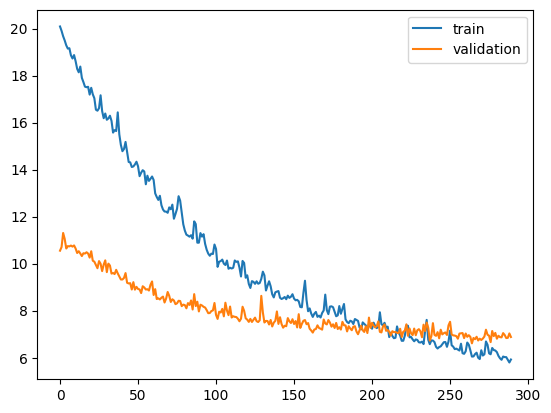

In [20]:
import matplotlib.pyplot as plt

start = 10
plt.plot(history.history['loss'][start:], label='train')
plt.plot(history.history['val_loss'][start:], label='validation')

plt.legend()
plt.show()

In [21]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [22]:
y_pred_train = model.predict(x_train_windows)
y_pred_test = model.predict(x_test_windows)

print(evaluate_model(y_train_windows, y_pred_train))
print(evaluate_model(y_test_windows, y_pred_test))

301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'mse': 194.28786157650313, 'r2': 0.9433449362181026, 'mae': 5.818277154220059, 'mape': 128514285957648.7}
{'mse': 10.124163311599302, 'r2': 0.9671103923801277, 'mae': 2.1166623306906875, 'mape': 35059223551974.03}


In [23]:
x_test_windows.shape

(1244, 10, 164)

In [24]:
baseline_predictions = []

for x in x_test_windows:
    baseline_predictions.append(x[-1][-1])

baseline_predictions = np.array(baseline_predictions).reshape(-1, 1)
print(evaluate_model(y_test_windows, baseline_predictions))

{'mse': 229.48277331189712, 'r2': 0.2544965803642203, 'mae': 10.168247588424439, 'mape': 55389931108336.664}


In [25]:
# model.save('../models/lstm_model.keras')

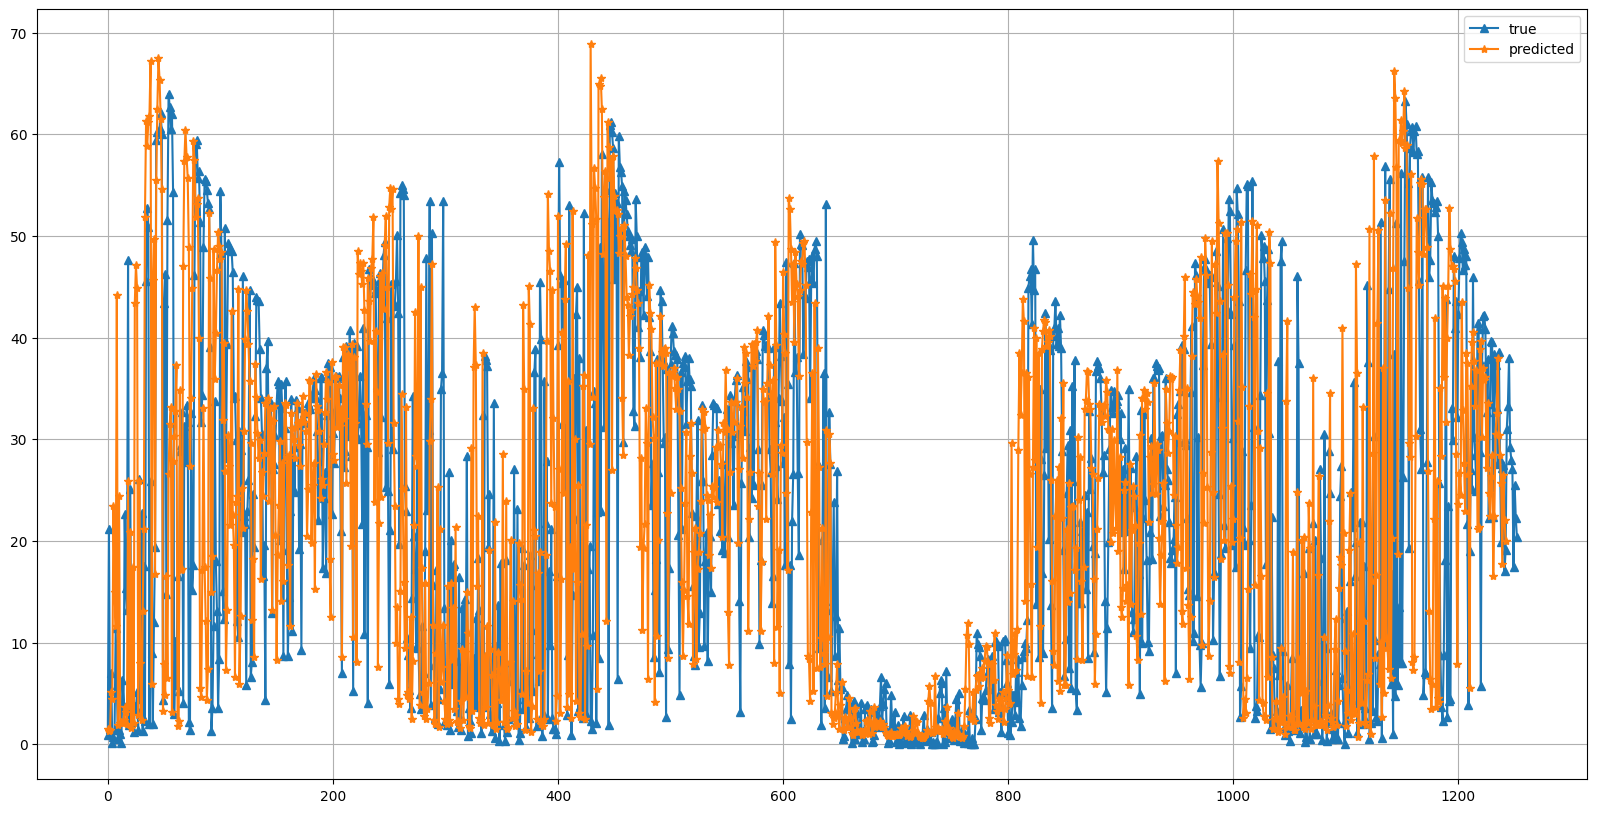

In [26]:
plt.figure(figsize=(20, 10))

start = 0
end = -1

plt.plot(y_test[start:end], '-^', label='true')
plt.plot(y_pred_test[start:end], '-*', label='predicted')

plt.legend()
plt.grid(True)
plt.show()